# Hazard rate infrences during binary estimation

## Alex Filipowicz, Derek Nuamah
### June 29th, 2019


### 0) Motivation

I've been thinking of a way to get people to use more/less complex models during learning. We've thought about using instructions, which I think is a good way to start, but the tasks we've been thinking about (mainly versions of the triangles task) are long, and may be hard to manipulate. Also, for neurophysiological measures like fMRI, which are pretty time limited, it may be more advantageous to use a different task.

The goal here is to layout an idea for a task that gets people to do a state estimation, while either considering or not considering that a hazard rate may apply. The idea is that the observations they are using for their state estimations could either be generated with or without a hazard rate, and that instructions could either match or not match the generative process on each trial. The goal would be to get people to use models of either appropriate complexity (when the instructions match the generative process), or over/under fit using models that are too complex or aren't complex enough.

### 1) Urn task idea

The basic idea for the task is that people see a series of beads pulled from urns with replacement. One urn contains 80 red beads/20 blue beads and the other 20 red beads/80 blue beads. On each trial, the subject's goal is to accurately report out of which urn the beads are being pulled from.

Subjects would be exposed to "blocks" of trials which could range from 1-5 trials (with uniform probability). Each block of trials will have beads drawn under two possible conditions: 

* 1) One urn condition: all of the beads will either be drawn from urn 1 (mostly red) or urn 2 (mostly blue) with replacement.


* 2) Person drawing condition: the beads will be drawn by one of two people, a person that tends to draw from one urn and rarely switches to the other (low switcher), or a person that switches frequently and predictably between urns (high switcher)

On each trial, a person would observe a bead draw, then predict from which urn the next bead draw will come. I was also thinking that they could give a continuous confidence judgement (using a slider).

The idea here is that you could give people instructions at the start of each trial block, which, if they are following instruction appropriately, should have very predictable consequences for the dynamics of their uncertainty.

### 2) Urn Estimation task - behavioral predictions

Part of the advantage for this task is that the main prediction occurs within the first two trials. After one observation, a subject thinking only about the urn, and not the hazard rate, should increase her/his confidence in which urn generated the bead. Conversely, a subject thinking about which person is drawing beads needs at least two observations before being able to make any predictions about which urn will generate the next bead. If one person switches infrequently and another frequently, the observer needs at least two samples before being able to learn anything about which person is drawing the beads, and therefore which urn will be drawn from next.

Below is a bit of code in R to generate trials and simulate behavior from two models: one which only does urn inference, and another that also considers the hazard rate.

In [1]:
genTrials = function(ntrials,p,haz=F){
    # Function that generates observations either with or without a hazard rate
    # Arguments:
    #     - ntrials: number of trials for a particular block
    #     - p: bernoulli probability - below .5 means favors 'red' urn, above .5 favors 'blue' urn
    #     - h: hazard rate - how often the urns switch - if set to False (F) beads are drawn from one urn
    #
    # Output:
    #     - data frame with a column for trials, hazard rate (if applicable), urn generating beads, and observed beads
    
    if(haz == F){
        urns = rep(sample(c(0,1),1),ntrials)
        beads = ifelse(urns == 1,as.numeric(runif(ntrials) < p), as.numeric(runif(ntrials) > p))
    }
    else{
        beads = rep(NA,ntrials)
        urns = rep(NA,ntrials)
        currUrn = sample(c(0,1),1) #0 indicates red urn, 1 indicates blue urn
        for(t in 1:ntrials){
            beads[t] = as.numeric(ifelse(currUrn == 1,runif(1) < p,runif(1) > p))
            urns[t] = currUrn
            currUrn = ifelse(runif(1) < haz,c(0,1)[currUrn != c(0,1)],currUrn)
        }
    }
    return(data.frame(Trials = 1:ntrials,
                     Hazard = ifelse(haz == F,rep(NA,ntrials),rep(haz,ntrials)),
                     Urns = urns,
                     Beads = beads))
}

Next are two ideal observer models that we will use to make our predicitions.

#### 2.1) Model 1: State estimator - no hazard rate

The first model estimates which of the two urn is most likely the one from which beads are being drawn. This model is a pretty straightforward perfect accumulator with no leak. On any trial $t$ within a trial block, the probability that the next bead $b$ will be generated by an urn $u$ on trial $t+1$ can be computed as follows: 

$$ p(u_{t+1}|b_{1:t}) = \frac{p(b_{1:t}|u_{t+1})p(u_{t+1})}{\sum_{u \in{[red, blue]}}p(b_{1:t}|u_{t+1})p(u_{t+1})}$$

The code below generates responses from this type of estimator.

In [2]:
stateEstimator = function(beads,urns,pspace,h = F,pprior = c(.5,.5),haz = F){
    # Function that generates responses from a perfect accumulator state estimator
    # Arguments:
    #     - beads: observed sequence of beads
    #     - pspace: space of bernoulli probabilities p that could apply to the urns - larger space = more urns to consider
    #     - urns: urns generating the beads (for data)
    #     - haz: hazard rate (if applicable - for data)
    #     - pprior: prior over urn space - defaults to uniform
    # Output:
    #     - data frame with a column for trials, estimator type, hazard rate (if applicable), urn generating beads, observed beads, confidence in the blue urn, confidence in the correct urn
    prior = matrix(NA,nrow = length(pspace),ncol = length(beads))
    posterior = prior
    for(t in 1:length(beads)){
        if(t == 1){
            prior[,t] = pprior
        }
        else{
            prior[,t] = posterior[,t-1]
        }
        likelihood = pspace
        if(beads[t] == 0){
            likelihood = 1-pspace 
        }
        posterior[,t] = prior[,t]*likelihood
        posterior[,t] = posterior[,t]/sum(posterior[,t])
    }
    prior_blue = prior[2,]
    if(haz == F){
        hazard = rep(NA,length(beads))
    }
    else{
        hazard = rep(haz,length(beads))
    }
    return(data.frame(Trials = 1:length(beads),
                     Estimator = rep('State',length(beads)),
                     Hazard = hazard,
                     Urns = urns,
                     Beads = beads,
                     Prior_Urn = prior_blue,
                     Posterior_Urn = posterior[2,],
                     Prior_Hazard = rep(NA,length(beads)),
                     Posterior_Hazard = rep(NA,length(beads)),
                     Correct_Urn = ifelse(urns == 1,prior_blue,1-prior_blue),
                     Correct_Hazard = rep(NA,length(beads))))
}

In a situation where beads are being drawn from one urn with replacement, this model provides an ideal observer solution. Importantly, we can see how this model's belief strength changes as a funciton of the amount of evidence it receives.

Below are simulations from a model seeing 5 draws from randomly choosen urns (100 trial blocks). As you can see, confidence in the correct urn increases rapidely after seeing the first bead.

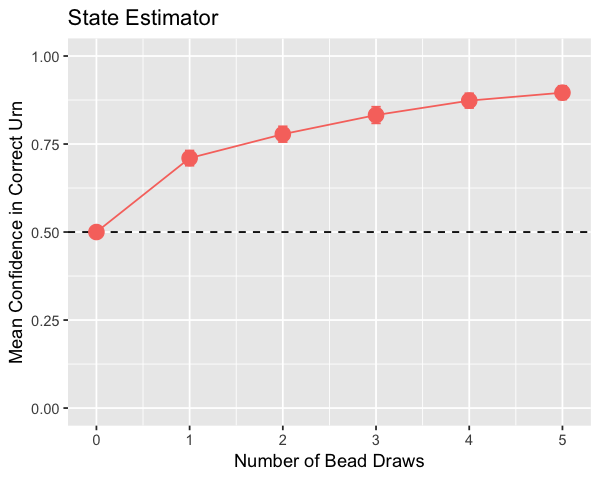

In [3]:
draws = genTrials(6,.8)
se_sim = stateEstimator(draws$Beads,draws$Urns,c(.2,.8))
for(i in 2:100){
    draws = genTrials(6,.8)
    se_sim = rbind(se_sim,stateEstimator(draws$Beads,draws$Urns,c(.2,.8)))
}

#Plot simulations
library(plyr)
library(ggplot2)
se_sim.m = ddply(se_sim,.(Trials),summarize,mcorrect = mean(Correct_Urn),mse=mean_se(Correct_Urn)[[2]],pse=mean_se(Correct_Urn)[[3]])

gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

n = 1
cols = gg_color_hue(n)

library(repr)
options(repr.plot.width=5,repr.plot.height=4)
ggplot(se_sim.m,aes(Trials,mcorrect,ymin=mse,ymax=pse))+
    geom_hline(yintercept=c(.5),linetype=2)+
    geom_line(color=cols)+
    geom_errorbar(width=.1,color=cols)+
    geom_point(size=4,color=cols)+
    ggtitle('State Estimator')+
    ylim(c(0,1))+
    ylab('Mean Confidence in Correct Urn')+
    xlab('Number of Bead Draws')+
    scale_x_continuous(breaks=1:6,labels=0:5)

#### 2.2) Model 2: State estimator - with hazard rate

Another model that could be used in this scenario is one that expect volatility (hazard rate $H$) in the environment. If the hazard rate is unknown, the model must jointly infer the hazard rate over all considered values of $H$ *and* all possible states in order to make its confidence judgements. This would be done as follows:

$$ p(u_{t+1},h|b_{1:t}) = \frac{p(b_{1:t}|u_{t+1},h)p(u_{t+1},h)}{\sum_{h \in{H}}\sum_{u \in{[red, blue]}}p(b_{1:t}|u_{t+1},h)p(u_{t+1},h)}$$

Where the model's urn estimate $p(u_{t+1}|x_{1:t})$ can be obtained by marginalizing over $p(H)$. The code below creates this type of estimator.

In [4]:
hazardEstimator = function(beads,urns,pspace,hspace,haz=F){
    prior = array(NA, c(length(pspace),length(hspace),length(beads)))
    posterior = array(NA, c(length(pspace),length(hspace),length(beads)))
    
    for(i in 1:length(beads)){
        #Get prior
        if(i == 1){
            prior[,,i] = 1/(length(pspace)*length(hspace))
        }
        else{
            #update prior based on hazards being considered
            prior[,,i] = posterior[,,i-1]
            
            for(h in 1:length(hspace)){
                pO = prior[1,h,i]
                pB = prior[2,h,i]
                prior[1,h,i] = (1-hspace[h])*pO + hspace[h]*pB
                prior[2,h,i] = (1-hspace[h])*pB + hspace[h]*pO
            }
        }
        
        #Update state estimations based on observed bead
        if(beads[i] == 1){
            lik = pspace
        }
        else{
            lik = 1-pspace
        }
        posterior[,,i] = prior[,,i]
        for(h in 1:length(hspace)){
            posterior[,h,i] = prior[,h,i]*lik
        }
        posterior[,,i] = posterior[,,i]/sum(posterior[,,i])
    }
    
    #Get data frame of responses and confidence values
    prior_blue = sapply(1:length(beads),function(x) rowSums(prior[,,x]))[2,]
    posterior_blue = sapply(1:length(beads),function(x) rowSums(posterior[,,x]))[2,]
    prior_hi = sapply(1:length(beads),function(x) colSums(prior[,,x]))[2,]
    posterior_hi = sapply(1:length(beads),function(x) colSums(posterior[,,x]))[2,]
    df = data.frame(Trials = 1:length(beads),
                    Estimator = rep('Hazard',length(beads)),
                    Hazard = rep(haz,length(beads)),
                    Urns = urns,
                    Beads = beads,
                    Prior_Urn = prior_blue,
                    Posterior_Urn = posterior_blue,
                    Prior_Hazard = prior_hi,
                    Posterior_Hazard = posterior_hi,
                    Correct_Urn = ifelse(urns == 1,prior_blue,1-prior_blue),
                    Correct_Hazard = ifelse(rep(haz,length(beads))==hspace[2],prior_hi,1-prior_hi))
    return(list(Prior = prior,Posterior = posterior,Responses = df))
}

Under certain conditions, this model makes very interesting predictions about how belief strength accumulates with each new observation. If one of the values of $H$ considered is below .5 and the other above .5, and the model has a uniform prior over $H$, the model needs a minimum of 2 obsevations in order to start building confidence in knowing which urn is generating beads. This is because with one observation, the model does not know whether or not the urn will remain stable (in regimes were $H < .5$) or switch (in regimes where $H > .5$).

Below are simulations from this model's confidence in the same task as the state estimator. As you can see, the state estimator does better in this environment because the hazard estimator is busy trying to figure out the hazard rate to then inform it's state estimates. Note the consistent qualitative difference in confidence after having seen only one bead.

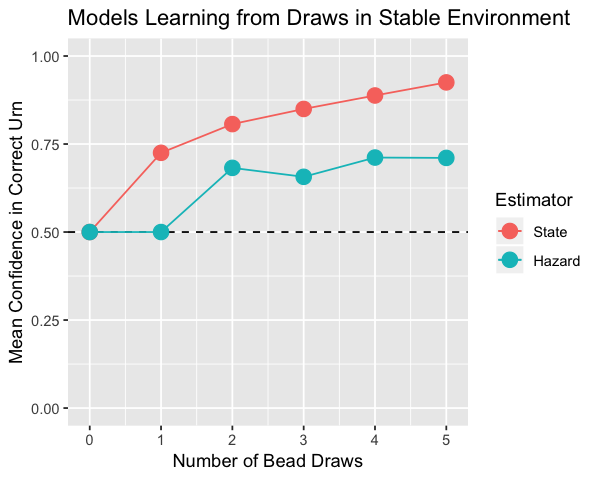

In [5]:
#Function to simulate draws from state and hazard learner
genSim = function(nsim,ntrials,pspace,hspace,p,h=F){
    draws = genTrials(ntrials,p,haz = h)
    se_sim = stateEstimator(draws$Beads,draws$Urns,pspace,haz=h)
    he_sim = hazardEstimator(draws$Beads,draws$Urns,pspace,hspace,haz=h)$Responses
    for(i in 2:nsim){
        draws = genTrials(ntrials,p,haz = h)
        se_sim = rbind(se_sim,stateEstimator(draws$Beads,draws$Urns,pspace,haz=h))
        he_sim = rbind(he_sim,hazardEstimator(draws$Beads,draws$Urns,pspace,hspace,haz=h)$Responses)
    }
    return(rbind(se_sim,he_sim))
}
#Generate draws
library(ggplot2)
library(plyr)
sims = genSim(200,6,c(.2,.8),c(.05,.95),.8)
sims.m = ddply(sims,.(Estimator,Trials),summarize,mcorrect = mean(Correct_Urn),mse=mean_se(Correct_Urn)[[2]],pse=mean_se(Correct_Urn)[[3]])

library(repr)
options(repr.plot.width=5,repr.plot.height=4)
ggplot(sims.m,aes(Trials,mcorrect,ymin=mse,ymax=pse,color=Estimator))+
    geom_hline(yintercept=c(.5),linetype=2)+
    geom_line()+
    geom_errorbar(width=.1)+
    geom_point(size=4)+
    ggtitle('Models Learning from Draws in Stable Environment')+
    ylim(c(0,1))+
    ylab('Mean Confidence in Correct Urn')+
    xlab('Number of Bead Draws')+
    scale_x_continuous(breaks=1:6,labels=0:5)

We shoudl expect the hazard estimator to do better in an unstable environment. This is true in the limit of infite samples, but not necessary true when the number of bead draws is too low. Below are simulations of the difference between the state estimator vs the hazard estimator in low and high hazard learning conditions. As you can see, with only 5 draws, the state estimator outperforms the hazard estimator in the low hazard rate condition - this is mainly because the switch rate is too low to have a strong effect after 5 trials, and perfect accumulation is always better before a switch than leaky accumulation.

The main condition under which the hazard learning model gains an advantage is in the high hazard rate condition. Here switches occur so frequently that perfect accumulation fails. The hazard model, however, is able to identify that switches are frequent and start building a correct predictive model in this environment.

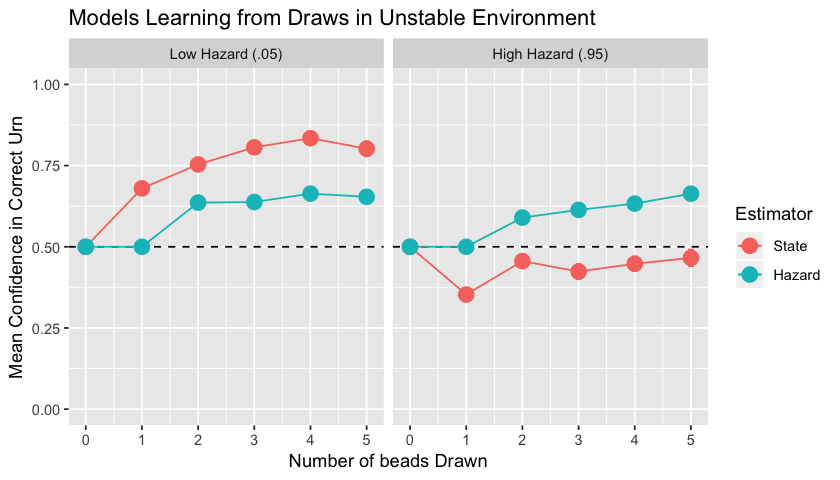

In [6]:
#Simulations with low and high hazard rates
sims_h_low = genSim(200,6,c(.2,.8),c(.05,.95),.8,h=.05)
sims_h_high = genSim(200,6,c(.2,.8),c(.05,.95),.8,h=.95)
sims_h = rbind(sims_h_low,sims_h_high)
sims_h.m = ddply(sims_h,.(Estimator,Hazard,Trials),summarize,mcorrect = mean(Correct_Urn),mse=mean_se(Correct_Urn)[[2]],pse=mean_se(Correct_Urn)[[3]])
sims_h.m$Hazard = factor(sims_h.m$Hazard,labels=c('Low Hazard (.05)','High Hazard (.95)'))
library(repr)
options(repr.plot.width=7,repr.plot.height=4)
ggplot(sims_h.m,aes(Trials,mcorrect,ymin=mse,ymax=pse,color=Estimator))+
    geom_hline(yintercept=c(.5),linetype=2)+
    geom_errorbar(width=.1)+
    geom_line()+
    geom_point(size=4)+
    facet_wrap(~Hazard)+
    ylab('Mean Confidence in Correct Urn')+
    xlab('Number of beads Drawn')+
    ggtitle("Models Learning from Draws in Unstable Environment")+
    ylim(c(0,1))+
    scale_x_continuous(breaks=1:6,labels=0:5)

### 3) Potential task ideas

#### 3.1) Urn prediction task
This seems like a potentially good task to manipulate people's complexity. We give people different blocks of trials, some which have a hazard rate and some which do not. People would be told that on some blocks of trials beads are being drawn from one urn, and one urn only. On other blocks, one of two people are drawing beads from the urns and switching between the urns at either a slow or fast pace. The participant's job is to report which urn they think the next bead will be drawn from (and maybe report how confident they are in their report).

A cool manipulation would be to have all possible combinations, where people are told that a hazard does or does not apply for a block or trials, and where the see trials that do or do not have a hazard rate. We should definitely expect that people's estimates will differ depending on whether or not they are considering the hazard rate, particularly on the first two trials, even if they observe the same sequence of beads.

#### 3.2) Urn vs Hazard estimation task

This is something Derek (undergraduate in Joe's lab) and I have been working on. Here we're trying to dissociate uncertainty over the state space from uncertainty over the hazard space.

People are given two blocks of trials - one in which there is no hazard rate and they are asked to report their confidence that beads are being drawn from an 80% blue or 80% red urn, and another block where they report whether a low switching person or high switching person are drawing the beads (i.e., hazard rates of .2 and .8 respectively).

Similar to what I've highlighted above, the main prediction is that uncertainty over the state space can be reduced within after seeing the first bead, whereas uncertainty cannot be reduced in the hazard estimation part until at least 2 beads have been observed.

Here are some simulations of how uncertainty dynamics should operate over the state and hazard space using the ideal observers above. Similar to what we see above, the real qualitative difference occurs within the first two bead presentations - after 1 bead we can be confident in which urn is generating the beads, whereas to identify which person is drawing from the urns we need at least two observations. 

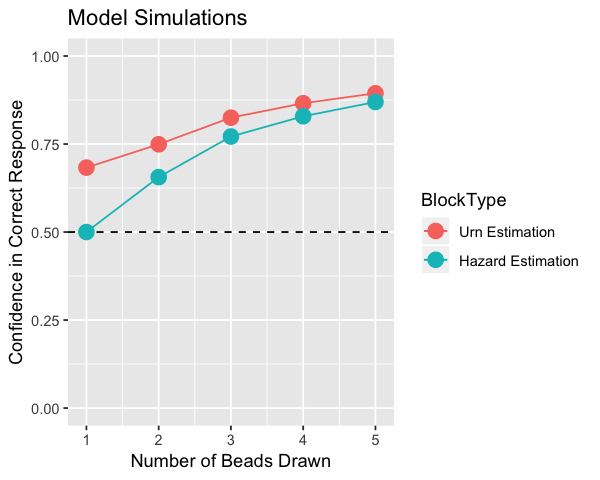

In [34]:
sims_urn = genSim(200,6,c(.2,.8),c(.05,.95),.8)
sims_haz_low = genSim(100,6,c(.00001,.99999),c(.2,.8),.9999,h=.2)
sims_haz_high = genSim(100,6,c(.00001,.99999),c(.2,.8),.9999,h=.8) 
sims_haz = rbind(sims_haz_low,sims_haz_high)

sims_urn.m = ddply(subset(sims_urn,Estimator == 'State'),.(Trials),summarize,mcorrect = mean(Correct_Urn),mse=mean_se(Correct_Urn)[[2]],pse=mean_se(Correct_Urn)[[3]])
sims_urn.m$BlockType = 'Urn Estimation'
sims_haz.m = ddply(subset(sims_haz,Estimator == 'Hazard'),.(Trials),summarize,mcorrect=mean(Correct_Hazard),mse=mean_se(Correct_Hazard)[[2]],pse=mean_se(Correct_Hazard)[[3]])
sims_haz.m$BlockType = 'Hazard Estimation'
sims.m = rbind(sims_urn.m,sims_haz.m)
sims.m$BlockType = factor(sims.m$BlockType,levels=c('Urn Estimation','Hazard Estimation'))

options(repr.plot.width=5,repr.plot.height=4)
ggplot(subset(sims.m,Trials > 1),aes(Trials,mcorrect,ymin=mse,ymax=pse,color=BlockType))+
    geom_hline(yintercept=c(.5),linetype=2)+
    geom_errorbar(width=.1)+
    geom_line()+
    geom_point(size=4)+
    ylab('Confidence in Correct Response')+
    xlab('Number of Beads Drawn')+
    scale_x_continuous(breaks=1:6,labels=0:5)+
    ylim(c(0,1))+
    ggtitle('Model Simulations')

The main goal here is to identify whether uncertainty at different hierachical levels is represented in the same or different ways by the brain. There are three anticipated steps here:

    -1) Show that these qualitative differences in uncertainty that occur after the first two trials show up in people's confidence reports (i.e., their uncertainty is driven by the state or the hazard rate in each respective block).
    
    -2) See if this context dependent uncertainty presents itself in neurophysiological signals (pupils to start)
    
    -3) See if these two different types of uncertainty are represented the same way or differently in the brain (via fMRI)

### 4) DATA!!!

#### 4.1) Analysis for the Urn and Hazard Estimation task

The code below reproduces the figures above (in section 3.2) to see if our context manipulation is having the desired effect.

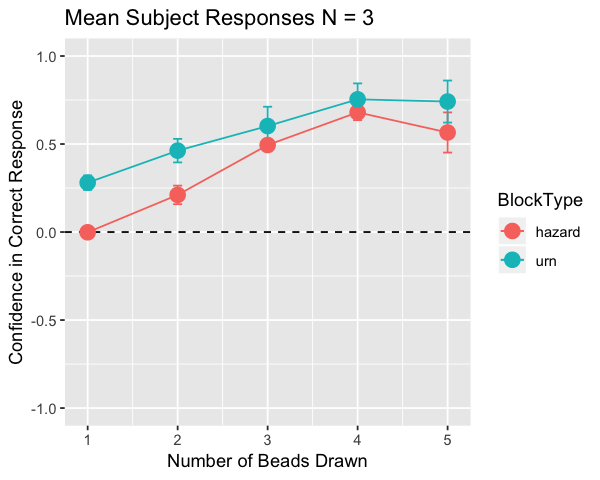

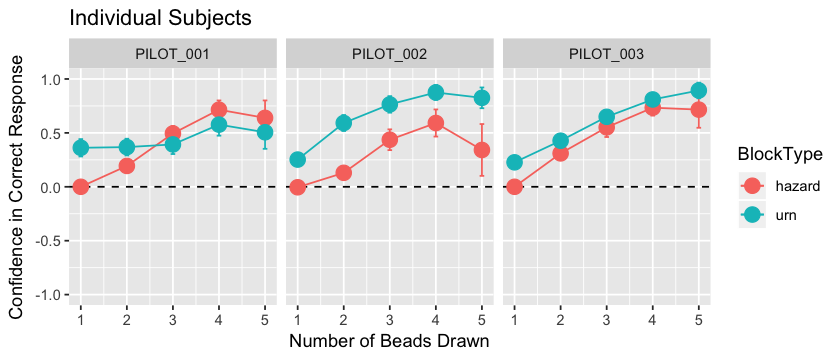

In [32]:
# 1) Load data from all pilot subjects
path = getwd()
dpath = paste0(path,'/task/data/Pilot/')

dfiles = dir(dpath,pattern='PILOT')

pdat = read.csv(paste0(dpath,dfiles[1]),sep=',',stringsAsFactors=F)
for(i in 2:length(dfiles)){
    pdat = rbind(pdat,read.csv(paste0(dpath,dfiles[i]),sep=',',stringsAsFactors=F))
}

# 2) Data clean up
#Get rid of reward trials
pdat = subset(pdat,is.na(pdat$Bead)==0)

# Compute confidence in correct response
pdat$Conf_Correct[pdat$Prediction == pdat$CurrGen] = pdat$Confidence[pdat$Prediction == pdat$CurrGen]
pdat$Conf_Correct[pdat$Prediction != pdat$CurrGen] = -pdat$Confidence[pdat$Prediction != pdat$CurrGen]
pdat$Conf_Correct[pdat$Prediction == 'None'] = 0

# 2) Get summary that we can plot
library(plyr)
library(ggplot2)

#Individual subjects
pdat.p = ddply(pdat,.(SubjectID,BlockType,TrialNumber),summarize,mconf = mean(Conf_Correct),mse=mean_se(Conf_Correct)[[2]],pse=mean_se(Conf_Correct)[[3]])

# Mean across subject
pdat.m = ddply(pdat.p,.(BlockType,TrialNumber),summarize,Conf_Correct = mean(mconf),mse=mean_se(mconf)[[2]],pse=mean_se(mconf)[[3]])

options(repr.plot.width=5,repr.plot.height=4)
ggplot(pdat.m,aes(TrialNumber,Conf_Correct,ymin=mse,ymax=pse,color=BlockType))+
geom_hline(yintercept=c(0),linetype=2)+
geom_errorbar(width=.1)+
geom_line(aes(group = BlockType))+
geom_point(size=4)+
ylim(c(-1,1))+
ylab('Confidence in Correct Response')+
xlab('Number of Beads Drawn')+
ggtitle(paste0('Mean Subject Responses N = ',as.character(length(dfiles))))

#Plot each subject's responses
options(repr.plot.width=7,repr.plot.height=3)
ggplot(pdat.p,aes(TrialNumber,mconf,ymin=mse,ymax=pse,color=BlockType))+
geom_hline(yintercept=c(0),linetype=2)+
geom_errorbar(width=.1)+
geom_line(aes(group = BlockType))+
geom_point(size=4)+
facet_wrap(~SubjectID)+
ylim(c(-1,1))+
ylab('Confidence in Correct Response')+
xlab('Number of Beads Drawn')+
ggtitle('Individual Subjects')

In [36]:
#Stats
library(lme4)
library(lmerTest)

lme_dat = pdat[,c(1,5,7,18)]
lme_dat$TrialNumber = scale(pdat$TrialNumber)
lme_dat$Conf_Correct = scale(pdat$Conf_Correct)

#Diff on trial 1
t1_dat = subset(pdat,TrialNumber == 1)
t1_lme = lmer(Conf_Correct~BlockType+(1|SubjectID),t1_dat)
print(summary(t1_lme))

#Diff on trial 2
t2_dat = subset(pdat,TrialNumber == 2)
t2_lme = lmer(Conf_Correct~BlockType+(1|SubjectID),t2_dat)
print(summary(t2_lme))

#Diff on trial 3
t3_dat = subset(pdat,TrialNumber == 3)
t3_lme = lmer(Conf_Correct~BlockType+(1|SubjectID),t3_dat)
print(summary(t3_lme))

#Diff on trial 4
t4_dat = subset(pdat,TrialNumber == 4)
t4_lme = lmer(Conf_Correct~BlockType+(1|SubjectID),t4_dat)
print(summary(t4_lme))

#Diff on trial 5
t5_dat = subset(pdat,TrialNumber == 5)
t5_lme = lmer(Conf_Correct~BlockType+(1|SubjectID),t5_dat)
print(summary(t5_lme))



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Conf_Correct ~ BlockType + (1 | SubjectID)
   Data: t1_dat

REML criterion at convergence: 264.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4841 -0.0256  0.0232  0.3873  1.9542 

Random effects:
 Groups    Name        Variance  Std.Dev.
 SubjectID (Intercept) 0.0003282 0.01812 
 Residual              0.1187665 0.34463 
Number of obs: 360, groups:  SubjectID, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   -0.00150    0.02773   6.11228  -0.054    0.959    
BlockTypeurn   0.28189    0.03633 356.00000   7.760 9.09e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
BlockTypern -0.655
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Conf_Correct ~ BlockType + (1 | SubjectID)
   Data: t2_dat

REML criterion at c